In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/tmp/ipykernel_137546/1425855459.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-13 23:21:36.729589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 23:21:36.729634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 23:21:36.730329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable

In [2]:
game_threshold = 4 # minimum number of games to be in the dataset
test_size = 0.2 # % of the dataset is used for testing
ModelHasBot = True #  if True, the bot is considered as a player - to consider bot statistics in games 2vs3 or 3vs4
timeStart ='' #'2023-03-01' # start date of the dataset
present_players = ['Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун','Сеньор','Юран']

# 'Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша', 'Ондрей', 'Савва', 'Сеньор', 'Юран'


# Data preprocessing

In [3]:
dataset = pd.read_csv('data.csv') 
columnsPlayers = ["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]
columnsTeam1 = ["Player1","Player2","Player3","Player4"]
columnsTeam2 = ["Player5","Player6","Player7","Player8"]

In [4]:
dataset["Map"] = dataset["Map"].str.lower() # convert all maps to lower case
dataset['Date'] = pd.to_datetime(dataset['Date'],format='%d.%m.%Y') # convert date to datetime
dataset=dataset.drop_duplicates(subset=['Date','Map']) # drop duplicates with same date and map
dataset.to_csv('new_data.csv',index=False) # save the new dataset
print(dataset.Recorder.value_counts()) # count the number of games played by each player
dataset.drop(columns=['link','Recorder','vs'],   inplace=True) # drop columns that are not needed

#  drop entries which were played before the start date
if timeStart != '':
    dataset = dataset[dataset['Date'] >= timeStart]



Recorder
(Сеньор)    34
(Ден)       33
(Гриша)     27
(Данил)     27
(Миша)       1
Name: count, dtype: int64


### Add column with number of maps in each campaign

In [5]:
map_weights = {
'ливень':5,
'кровавая жатва':5, 
'переход':3,
'мрачный карнавал':5,
'холодный ручей':4,
'похоронный звон':5,
'приход':5,
'смерть в воздухе':5,
'нет милосердию':5,
'вымерший центр':4,
'болотная лихорадка':4,
'последний рубеж':2,
'жертва':3,
'роковой полет':5}

def map_weight(map):
    return map_weights[map]

dataset["Map_weight"] = dataset["Map"].apply(map_weight)
dataset["Map_weight"] = dataset["Map_weight"]/ dataset["Map_weight"].max()# scale weight

dataset.Map.value_counts()

Map
смерть в воздухе      13
нет милосердию        13
переход               12
мрачный карнавал      12
приход                11
похоронный звон       10
ливень                 9
кровавая жатва         9
вымерший центр         9
холодный ручей         7
жертва                 6
болотная лихорадка     4
последний рубеж        4
роковой полет          3
Name: count, dtype: int64

#### Unique players and cleaning those with small statistics

In [112]:
# unique players from all 8 columns ["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]
players = np.unique(dataset[columnsPlayers].values)
players = pd.DataFrame(players, columns=["Player"])
# filter players that have played more than 'game_threshold' games
players = players[players["Player"].map(dataset[columnsPlayers].stack().value_counts()) >= game_threshold]
players = players["Player"].values

# remove rows with players not in the list
dataset = dataset[dataset[columnsPlayers].isin(players).all(axis=1)]

if not ModelHasBot: # remove bot from the list of players
    players = players[players != 'Бот']
players

array(['Бот', 'Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша',
       'Ондрей', 'Савва', 'Сеньор', 'Юран'], dtype=object)

In [115]:
remove_players = ['Ондрей/Джун', 'Ондрей/Сеньор', 'Марина']
# drop rows with some chosen remove_players in any of the 8 columns
def drop_players(row):
    for player in remove_players:
        if player in row.values:
            return False
    return True

dataset.drop(dataset[~dataset.apply(drop_players, axis=1)].index, inplace=True)

players = np.unique(dataset[["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]].values)

#  delete "Bot" from list
players = players[players != 'Бот']
players

array(['Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша', 'Ондрей',
       'Савва', 'Сеньор', 'Юран'], dtype=object)

In [116]:
# randonly assign 1 or 2 to TeamWon column
dataset["TeamWon"] = np.random.randint(1, 3, dataset.shape[0])
dataset

,Date,Map,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8,Map_weight,TeamWon
0,2024-03-09,ливень,Ден,Гриша,Ондрей,Юран,Сеньор,Савва,Данил,Бот,5,1
3,2024-03-03,кровавая жатва,Данил,Вадим,Сеньор,Савва,Гриша,Миша,Ден,Бот,5,2
6,2024-03-03,переход,Вадим,Сеньор,Юран,Гриша,Ден,Данил,Савва,Миша,3,2
8,2024-03-02,мрачный карнавал,Данил,Гриша,Сеньор,Савва,Вадим,Миша,Ваня,Бот,5,2
11,2024-02-25,холодный ручей,Ден,Вадим,Гриша,Бот,Юран,Сеньор,Ваня,Бот,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
205,2023-01-05,нет милосердию,Ден,Вадим,Миша,Сеньор,Джун,Данил,Юран,Ваня,5,2
210,2023-01-04,кровавая жатва,Ден,Данил,Ваня,Гриша,Миша,Ондрей,Джун,Вадим,5,1
211,2023-01-01,приход,Ваня,Сеньор,Миша,Ден,Данил,Ондрей,Джун,Гриша,5,1
212,2023-01-01,жертва,Сеньор,Джун,Ден,Вадим,Миша,Гриша,Ваня,Данил,3,2


In [117]:
# randomly assign 1 or 2 to TeamWon column
dataset["TeamWon"] = np.random.randint(1, 3, dataset.shape[0]) # 1 or 2

In [118]:
# Players from "Team 1" are Player1, Player2, Player3, Player4
# Players from "Team 2" are Player5, Player6, Player7, Player8
# TeamWon column is the team that won the game
#  assign to player in which team he was
for player in players:
    # make default value 0
    dataset[player] = 0
    dataset.loc[(dataset['Player1'] == player) | (dataset['Player2'] == player) | (dataset['Player3'] == player) | (dataset['Player4'] == player), player] = 1
    dataset.loc[(dataset['Player5'] == player) | (dataset['Player6'] == player) | (dataset['Player7'] == player) | (dataset['Player8'] == player), player] = 2
    if player=="Бот":
        dataset.loc[(dataset['Player4'] == "Бот") & (dataset['Player8'] == "Бот"), 'Бот'] = 0 # remove bot from statistics of 3 vs 3


In [119]:
#  add data with swapped players to lower values of absent players
swapped = dataset.copy()
swapped[columnsTeam1+columnsTeam2] = swapped[columnsTeam2+columnsTeam1]
# dataset = pd.concat([dataset, swapped])

,Date,Map,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8,Map_weight,TeamWon,Вадим,Ваня,Гриша,Данил,Ден,Джун,Миша,Ондрей,Савва,Сеньор,Юран
0,2024-03-09,ливень,Ден,Гриша,Ондрей,Юран,Сеньор,Савва,Данил,Бот,5,1,0,0,1,2,1,0,0,1,2,2,1
3,2024-03-03,кровавая жатва,Данил,Вадим,Сеньор,Савва,Гриша,Миша,Ден,Бот,5,2,1,0,2,1,2,0,2,0,1,1,0
6,2024-03-03,переход,Вадим,Сеньор,Юран,Гриша,Ден,Данил,Савва,Миша,3,2,1,0,1,2,2,0,2,0,2,1,1
8,2024-03-02,мрачный карнавал,Данил,Гриша,Сеньор,Савва,Вадим,Миша,Ваня,Бот,5,2,2,2,1,1,0,0,2,0,1,1,0
11,2024-02-25,холодный ручей,Ден,Вадим,Гриша,Бот,Юран,Сеньор,Ваня,Бот,4,1,1,2,1,0,1,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2023-01-05,нет милосердию,Джун,Данил,Юран,Ваня,Ден,Вадим,Миша,Сеньор,5,2,2,1,0,1,2,1,2,0,0,2,1
210,2023-01-04,кровавая жатва,Миша,Ондрей,Джун,Вадим,Ден,Данил,Ваня,Гриша,5,1,1,2,2,2,2,1,1,1,0,0,0
211,2023-01-01,приход,Данил,Ондрей,Джун,Гриша,Ваня,Сеньор,Миша,Ден,5,1,0,2,1,1,2,1,2,1,0,2,0
212,2023-01-01,жертва,Миша,Гриша,Ваня,Данил,Сеньор,Джун,Ден,Вадим,3,2,2,1,1,1,2,2,1,0,0,2,0


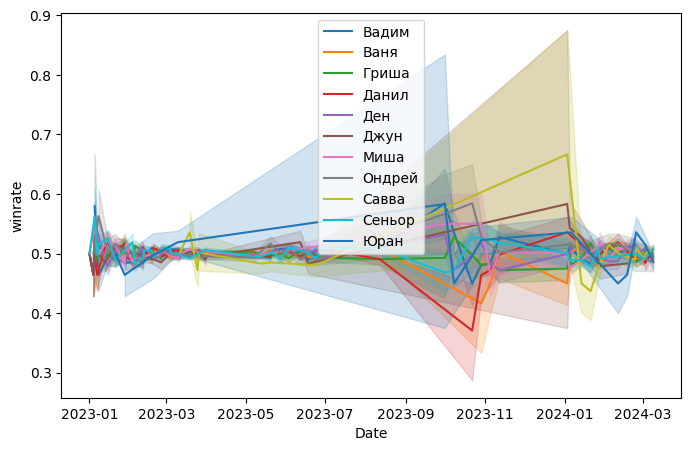

In [210]:
# plot individual player winrate during some period
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
slice_duration_days = 100


def plot_player_winrate(player):
    player_data = dataset[dataset[player] != 0]
    player_data = player_data.sort_values(by='Date')
    player_data = player_data.set_index('Date')

    player_data["win"] = player_data['TeamWon'] == player_data[player]
    player_data["win"] = player_data["win"].replace({player:1,0:0})
    player_data["win"] = player_data["win"].fillna(0)
    player_data["win"] = player_data["win"].astype(int)

    player_data["winrate"] = player_data["win"].rolling(f'{slice_duration_days}D').mean()


    # plot not every entry but only every 10th and skip first 5 entries
        
    player_data = player_data.iloc[5::1, :]
    player_data = player_data.reset_index()
    player_data = player_data.dropna()
    sns.lineplot(x=player_data['Date'], y=player_data['winrate'], label=player)

for player in players:
    plot_player_winrate(player)

plt.show()




## Train the model

In [ ]:
# plot  correlation between  players who won together

#  correlation between  players who won together
correlation = dataset[players].corr()
plt.figure(figsize=(10, 10))

sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()



In [ ]:
# split the dataset into train and test
train, test = train_test_split(dataset,  test_size=test_size, random_state=42)

# select the columns to predict
y_train = train['TeamWon']-1  # 0 or 1
y_test = test['TeamWon']-1 # 0 or 1

# select the columns to train the model
X_train = train[players]
w_train = train["Map_weight"]
X_test = test[players]
w_test = test["Map_weight"]

#  scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#  create a model
model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(len(players),), activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',

              # metrics=['accuracy'],
              weighted_metrics=['accuracy']
              )
# train the model
model.fit(X_train,
          y_train, 
          sample_weight=w_train,
          validation_data=(X_test, y_test, w_test), 
          epochs=10)
# test the model
print ("")
print ("Test")
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)

2024-03-13 23:21:38.302869: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Epoch 1/10


2024-03-13 23:21:38.320249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 23:21:38.320300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 23:21:38.322134: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 23:21:38.322198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 23:21:38.322229: I external/local_xla/xla/stream_executor

3/3 [==============================] - 1s 91ms/step - loss: 0.6145 - accuracy: 0.5490 - val_loss: 0.6096 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 0s 15ms/step - loss: 0.5915 - accuracy: 0.6005 - val_loss: 0.6076 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 0s 15ms/step - loss: 0.5749 - accuracy: 0.6495 - val_loss: 0.6069 - val_accuracy: 0.5392
Epoch 4/10
3/3 [==============================] - 0s 16ms/step - loss: 0.5609 - accuracy: 0.6691 - val_loss: 0.6067 - val_accuracy: 0.5686
Epoch 5/10
3/3 [==============================] - 0s 15ms/step - loss: 0.5487 - accuracy: 0.6814 - val_loss: 0.6085 - val_accuracy: 0.5196
Epoch 6/10
3/3 [==============================] - 0s 15ms/step - loss: 0.5363 - accuracy: 0.7230 - val_loss: 0.6106 - val_accuracy: 0.4706
Epoch 7/10
3/3 [==============================] - 0s 15ms/step - loss: 0.5254 - accuracy: 0.7230 - val_loss: 0.6113 - val_accuracy: 0.4706
Epoch 8/10
3/3 [======================

In [12]:
all_results = []
# add bots to the present players if there are less than 8 players
while len(present_players) < 8:
      present_players = present_players + ["Бот"]
print ('present_players are', present_players)
for i in range(0, len(present_players)):
    for j in range(i+1, len(present_players)):
        for k in range(j+1, len(present_players)):
            for l in range(k+1, len(present_players)):
                                team1 = [present_players[i], present_players[j], present_players[k], present_players[l]]
                                # subtract team 1 player form list of present players, "Бот" can be used many times
                                team2 = [x for x in present_players if x not in team1]
                                # if team 2 has less than 4 players, add "Бот" to team 2
                                while len(team2) < 4:
                                    team2.append("Бот")
                                row = pd.DataFrame([team1 + team2], columns=columnsPlayers)
                                 # assign 1 or 2 to each player based on the team
                                for player in players:
                                    row[player] = 0
                                    if player in team1:
                                        row[player] = 1
                                    if player in team2:
                                        row[player] = 2
                                # scale the data
                                row = scaler.transform(row[players])

                                # predict the result
                                result = model.predict(row, verbose=0)
                                all_results.append((team1, team2, result))
# sort the results
all_results.sort(key=lambda x: x[2], reverse=True)

In [13]:
# print the results
for i in range(0, len(all_results)):
    print(all_results[i][0], "vs", all_results[i][1], ":", all_results[i][2][0][0])

['Гриша', 'Данил', 'Джун', 'Сеньор'] vs ['Вадим', 'Ваня', 'Ден', 'Юран'] : 0.73295003
['Ваня', 'Данил', 'Джун', 'Сеньор'] vs ['Вадим', 'Гриша', 'Ден', 'Юран'] : 0.72796726
['Ваня', 'Гриша', 'Данил', 'Джун'] vs ['Вадим', 'Ден', 'Сеньор', 'Юран'] : 0.7183339
['Вадим', 'Ваня', 'Данил', 'Сеньор'] vs ['Гриша', 'Ден', 'Джун', 'Юран'] : 0.7068356
['Вадим', 'Гриша', 'Данил', 'Сеньор'] vs ['Ваня', 'Ден', 'Джун', 'Юран'] : 0.7059753
['Вадим', 'Ваня', 'Гриша', 'Сеньор'] vs ['Данил', 'Ден', 'Джун', 'Юран'] : 0.7050484
['Вадим', 'Ваня', 'Гриша', 'Данил'] vs ['Ден', 'Джун', 'Сеньор', 'Юран'] : 0.7029116
['Ваня', 'Гриша', 'Данил', 'Сеньор'] vs ['Вадим', 'Ден', 'Джун', 'Юран'] : 0.6983682
['Вадим', 'Данил', 'Джун', 'Сеньор'] vs ['Ваня', 'Гриша', 'Ден', 'Юран'] : 0.6935232
['Вадим', 'Гриша', 'Данил', 'Джун'] vs ['Ваня', 'Ден', 'Сеньор', 'Юран'] : 0.68707514
['Вадим', 'Ваня', 'Данил', 'Джун'] vs ['Гриша', 'Ден', 'Сеньор', 'Юран'] : 0.6866281
['Вадим', 'Ваня', 'Гриша', 'Джун'] vs ['Данил', 'Ден', 'Сеньор

In [14]:
#  take the middle of the list
middle = len(all_results) // 2
print ("best team by median:")
print(all_results[middle][0], "vs", all_results[middle][1], "with output=", all_results[middle][2][0][0])

best team by median:
['Вадим', 'Ден', 'Джун', 'Сеньор'] vs ['Ваня', 'Гриша', 'Данил', 'Юран'] with output= 0.6312353


In [15]:
# take closest to 50% result
closest = min(all_results, key=lambda x: abs(x[2] - 0.5))
print ("best team by model 50% result:")
print(closest[0], "vs", closest[1], "with output=", closest[2][0][0])

best team by model 50% result:
['Ваня', 'Гриша', 'Ден', 'Юран'] vs ['Вадим', 'Данил', 'Джун', 'Сеньор'] with output= 0.5049114
